# 1. Making classification data and getting it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# Make 1000 samples.
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

The make circles dataset is a binary classification problem. X contains 2 features which indicate the location of a point. The make circles dataset creates 2 circles from many points. We have to classify our points if they belong to one circle or the other.

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [5]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [6]:
# Make dataframe of the circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


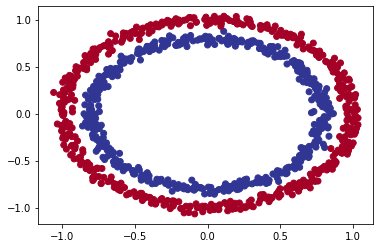

In [7]:
# Visualizing to better understand the data.
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,  # labels as y.
            cmap=plt.cm.RdYlBu)

The type of dataset we're working on is what people a toy dataset. A dataset which is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shape for 1 sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape for 1 sample of X: (2,) and the same for y: ()


y is a scalar. It doesn't have a dimension.

### 1.2 Turn data into tensor and create train and test splits

In [10]:
import torch
torch.__version__

'1.13.1+cu116'

In [11]:
X.dtype

dtype('float64')

In [12]:
# Split data into training and test splits.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
# Make device agnostic code.
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [14]:
from numpy import dtype
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [15]:
type(X_test), X_train.dtype, y_test.dtype

(torch.Tensor, torch.float32, torch.float32)

In [16]:
len(X_train), len(y_train)

(800, 800)

# 2. Building a model

- Set up a device agnostic code
- Construct a custom model
- Define loss and optimizer

In [17]:
# Import PyTorch and nn
import torch
import torch.nn as nn

In [18]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0')

After setting up the device agnostic code, lets create a model that:
1. Subclasses `nn.module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method for the forward pass.
4. Instantiate an instance of our model class and send it to the target `device`

In [19]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear() layers capable of handling the shapes of our data.
    self.layer1 = nn.Linear(2, 5)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(5, 1)
    self.sigmoid = nn.Sigmoid()

  # 3. Define the forward() method for our model
  def forward(self, x):
    output = self.sigmoid(self.layer2(self.relu(self.layer1(x))))
    return output

# 4. Instantiate the model of our class.
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [20]:
next(model_0.parameters()).device # Our model's parameters are on the cuda device.

device(type='cuda', index=0)

In [21]:
# Let's replicate the model above using nn.Sequential()
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.Tanh(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)

print(type(model_1))

<class 'torch.nn.modules.container.Sequential'>


We can also use sequential inside the init function, to stack up layers in a single variable.

In [22]:
model_1.state_dict()

OrderedDict([('0.weight', tensor([[-0.0138,  0.6193],
                      [ 0.0862, -0.0383],
                      [ 0.4349,  0.2857],
                      [ 0.6678,  0.4172],
                      [-0.6074,  0.3723],
                      [ 0.2736,  0.3450],
                      [ 0.3361, -0.0956],
                      [-0.2795,  0.1992],
                      [-0.6363,  0.6338],
                      [-0.0197,  0.2804],
                      [ 0.2619,  0.3268],
                      [ 0.1160, -0.3559],
                      [ 0.5195, -0.4206],
                      [ 0.1852,  0.6370],
                      [ 0.4226, -0.4845],
                      [-0.1583,  0.2928]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2384,  0.3606, -0.3661,  0.3983, -0.2898, -0.5207, -0.0274,  0.1555,
                      -0.2511,  0.1566,  0.2358,  0.0055,  0.5937,  0.6713, -0.5962, -0.0056],
                     device='cuda:0')),
             ('2.weight',
              ten

`squeeze()` reduces the dimension of the tensor to the lowest possible. Basically removes useless dimensions.

In [23]:
# Make predictions 
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
  print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
  print(f'\nFirst 10 predictions:\n{torch.round(untrained_preds[:10]).squeeze()}')
  print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


Our untrained model makes very bad predictions. We can see here that our predictions don't match the labels.

Logits: Logits are the output of the neural network without it being passed into the activation function.

## 2.1 Setup Loss and Optimizer
Since our problem is a binary classification task, we use the binary cross entropy function as our cost function.

We use normal stochastic gradient descent as our optimizer. We can also use Adam here and check out differences in performance between the two.

In [24]:
# Picking a loss function and optimizer.
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_1.parameters(), 0.1)

In [25]:
# Calculating the accuracy -
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

# 3. Train Model

To train our model, we are going to build a training loop. It has the following steps -
1. Make prediction
2. Calculate loss
3. Set optimizer gradients to zero (`optimizer.zero_grad()`)
4. Calculate gradients of the loss (`loss.backward()`)
5. Update our parameters (`optimizer.step()`)

### 3.1 Building a training and testing loop

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the hyperparameters
epochs = 1000

In [27]:
def train_test_loop(model):
  for epoch in range(epochs):
    # Setting model to train mode; activates tracking gradients
    model.train()

    # Forward pass
    y_pred = model(X_train).squeeze()

    # Loss calculation
    loss = criterion(y_pred, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred.round())

    # Setting gradients to zero
    optimizer.zero_grad()
    
    # Calculating new gradients
    loss.backward()

    # Updating our parameters.
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Forward pass.
      test_pred = (model(X_test)).squeeze()

      # Calculating test loss and accuracy
      test_loss = criterion(test_pred, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred.round())

    # Print out information according to what's happening -
    if epoch%10 == 0:
      print(f'Epoch: {epoch+1} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

In [28]:
train_test_loop(model_1)

Epoch: 1 | Loss: 0.69416, Acc: 49.12% | Test Loss: 0.69287, Test Acc: 48.00%
Epoch: 11 | Loss: 0.69308, Acc: 50.62% | Test Loss: 0.69192, Test Acc: 49.50%
Epoch: 21 | Loss: 0.69233, Acc: 51.25% | Test Loss: 0.69117, Test Acc: 53.50%
Epoch: 31 | Loss: 0.69167, Acc: 51.00% | Test Loss: 0.69046, Test Acc: 56.00%
Epoch: 41 | Loss: 0.69104, Acc: 51.38% | Test Loss: 0.68976, Test Acc: 56.00%
Epoch: 51 | Loss: 0.69043, Acc: 51.38% | Test Loss: 0.68905, Test Acc: 56.00%
Epoch: 61 | Loss: 0.68981, Acc: 51.25% | Test Loss: 0.68835, Test Acc: 56.00%
Epoch: 71 | Loss: 0.68920, Acc: 51.25% | Test Loss: 0.68765, Test Acc: 56.00%
Epoch: 81 | Loss: 0.68859, Acc: 52.38% | Test Loss: 0.68694, Test Acc: 56.50%
Epoch: 91 | Loss: 0.68797, Acc: 54.50% | Test Loss: 0.68624, Test Acc: 58.00%
Epoch: 101 | Loss: 0.68735, Acc: 57.38% | Test Loss: 0.68553, Test Acc: 62.00%
Epoch: 111 | Loss: 0.68671, Acc: 59.62% | Test Loss: 0.68480, Test Acc: 62.00%
Epoch: 121 | Loss: 0.68605, Acc: 61.12% | Test Loss: 0.68406, T

# 4. Make predictions and evaluate the model

From the metrics, it looks like our model isn't learning that much. So, let's try to visualize predictions.

To do so, we're going to import a function called `plot_decision_boundary()` from the link - https://www.github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [29]:
import requests
from pathlib import Path

link = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'

if Path('helper_functions.py').is_file():
  print('The file download already exists, skipping download.')
else:
  print('Download helper_functions.py')
  # Getting the data from the link.
  request = requests.get(link)

  # Creating the file and copying the content from the link into the file
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

The file download already exists, skipping download.


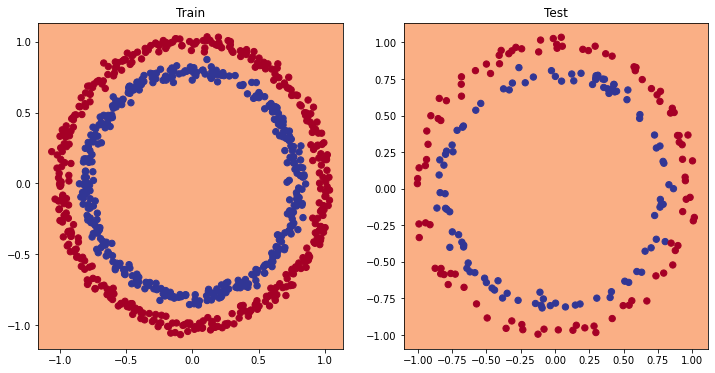

In [30]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)